# *Salix nigra* SLR: Population genomic analyses
Brian J. Sanderson

Last updated: 25 Mar 2020

In [1]:
# Libraries used in this notebook (R 3.6.2)
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))
suppressMessages(library(corrplot))
suppressMessages(library(reshape2))
suppressMessages(library(viridis))
suppressMessages(library(zoo))
suppressMessages(library(nlstools))
theme_set(theme_cowplot()); theme_update(plot.title = element_text(hjust = 0.5))

## Quantifying &pi;, Tajima's D, and LD genome-wide and across the SLR

This notebook begins with the filtered VCF file, which is the end result of the notebook titled [*Salix nigra* SLR: Variants](https://github.com/BrianSanderson/salix-nigra-slr/blob/master/notebooks/Salix-nigra-SLR-02-Variants.ipynb).

## Calculate site &pi; values for males and females

```males.txt``` and ```females.txt``` contain the name of each male and female from the VCF, one per line. These files will be used throughout this notebook.

```bash
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --keep males.txt \
         --max-alleles 2 \
         --out snigra_males \
         --site-pi

vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --keep females.txt \
         --max-alleles 2 \
         --out snigra_females \
         --site-pi
```

Read in male and female site &pi; values

In [2]:
Pi_frame <- bind_rows(read_delim("snigra_males.sites.pi", delim="\t",  na =c("", "NA", "-nan")) %>%
                          mutate(., sex = "male"),
                      read_delim("snigra_females.sites.pi", delim="\t",  na =c("", "NA", "-nan")) %>%
                          mutate(., sex = "female"))

Parsed with column specification:
cols(
  CHROM = col_character(),
  POS = col_double(),
  PI = col_double()
)

Parsed with column specification:
cols(
  CHROM = col_character(),
  POS = col_double(),
  PI = col_double()
)



In [3]:
Pi_frame <- Pi_frame %>%
    mutate(., CHROM = replace(CHROM, str_detect(CHROM, "scaffold"), "SC"),
              CHROM = str_replace(CHROM, "Chr0", ""),
              CHROM = str_replace(CHROM, "Chr15W", "15"),
              CHROM = str_replace(CHROM, "Chr", "")) %>%
    mutate(., CHROM = factor(CHROM, levels = c("1", "2", "3", "4", "5", "6",
                                               "7", "8", "9", "10", "11", "12", 
                                               "13", "14", "15", "16", "17", "18", 
                                               "19", "SC")))

Because we are calculating &pi; from the filtered VCF, we are only focusing on variant sites. Thus, 0 values don't make sense for this comparison (these are "SNPs" because they were called as such, but had genotypes filtered out downstream), and values of 1 seem unrealistic for this sample size. So I set 0 and 1 values to NA

In [4]:
Pi_frame <- mutate(Pi_frame, PI = replace(PI, PI == 0 | PI == 1, NA))

Calculate rolling means over 5000 SNP windows

In [5]:
Pi_frame <- group_by(Pi_frame, sex) %>%
                mutate(., roll5000 = rollapply(PI, 5000, mean, by = 5000, fill = NA, na.rm = TRUE)) %>%
            ungroup()

In [6]:
female_pi_rollQuantile.99 <- quantile(filter(Pi_frame, sex == "female") %>% 
                                        select(., roll5000) %>% 
                                        as_vector(),0.99,fill=NA,na.rm=TRUE)
female_pi_rollQuantile.01 <- quantile(filter(Pi_frame, sex == "female") %>% 
                                        select(., roll5000) %>% 
                                        as_vector(),0.01,fill=NA,na.rm=TRUE)
male_pi_rollQuantile.99 <- quantile(filter(Pi_frame, sex == "male") %>% 
                                      select(., roll5000) %>% 
                                      as_vector(),0.99,fill=NA,na.rm=TRUE)
male_pi_rollQuantile.01 <- quantile(filter(Pi_frame, sex == "male") %>% 
                                      select(., roll5000) %>% 
                                      as_vector(),0.01,fill=NA,na.rm=TRUE)

## Plot of male &pi; values on Chr 07

The red lines represent the genome-wide 1% and 99% quantiles for &pi;

In [7]:
plot_pi_male <- filter(Pi_frame, CHROM == "7" & sex == "male") %>%
    ggplot(., aes(x=POS, y=PI)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.1, size=1/100) +
        labs (x = "Position on Chromosome 7 (MB)", y=expression(pi)) +
        scale_color_manual(values = rep(c("black", "darkgray"), 1 )) +
        scale_x_continuous( breaks = c(0,2000000,4000000,6000000,8000000,10000000,12000000), 
                           labels=c("0","2","4","6","8","10","12")) +
        theme(legend.position = "none",
            axis.title.x = element_text(size=10), 
            axis.title.y = element_text(size=12), 
            axis.text.y = element_text(size=8),
            axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(Pi_frame, CHROM == "7" & sex == "male") %>% 
                                 select(., PI), 5000, fill=NA, na.rm=TRUE))) + 
        geom_hline(yintercept=male_pi_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=male_pi_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 67474 rows containing missing values (geom_point).”
Warning message:
“Removed 4999 rows containing missing values (geom_path).”


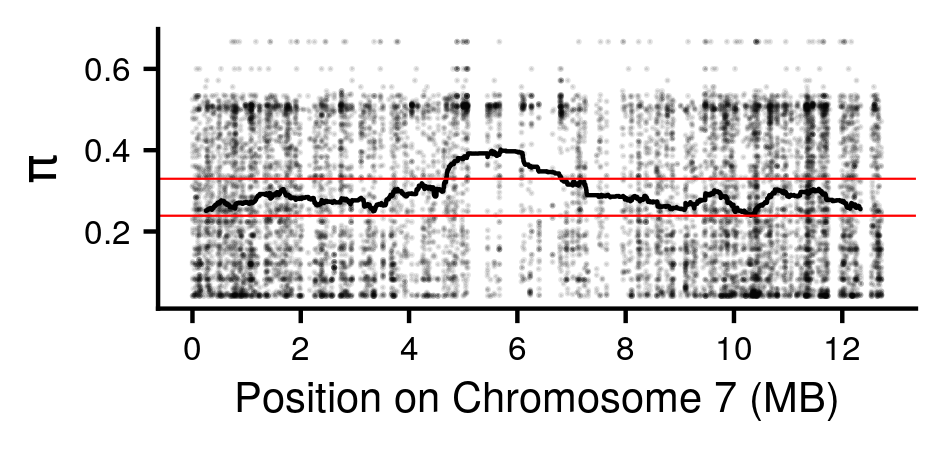

In [8]:
options(repr.plot.width = 3.15, repr.plot.height = 1.515, repr.plot.res = 300)
plot_pi_male

## Plot of female &pi; values on Chr 07

The red lines represent the genome-wide 1% and 99% quantiles for &pi;

In [9]:
plot_pi_female <- filter(Pi_frame, CHROM == "7" & sex == "female") %>%
    ggplot(., aes(x=POS, y=PI)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.1, size=1/100) +
        labs (x = "Position on Chromosome 7 (MB)", y=expression(pi)) +
        scale_color_manual(values = rep(c("black", "darkgray"), 1 )) +
        scale_x_continuous( breaks = c(0,2000000,4000000,6000000,8000000,10000000,12000000),
                           labels=c("0","2","4","6","8","10","12")) +
        theme(legend.position = "none",
            axis.title.x = element_text(size=10), 
            axis.title.y = element_text(size=12), 
            axis.text.y = element_text(size=8),
            axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(Pi_frame, CHROM == "7" & sex == "female") %>% 
                                 select(., PI), 5000, fill=NA, na.rm=TRUE))) + 
        geom_hline(yintercept=female_pi_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=female_pi_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 67603 rows containing missing values (geom_point).”
Warning message:
“Removed 4999 rows containing missing values (geom_path).”


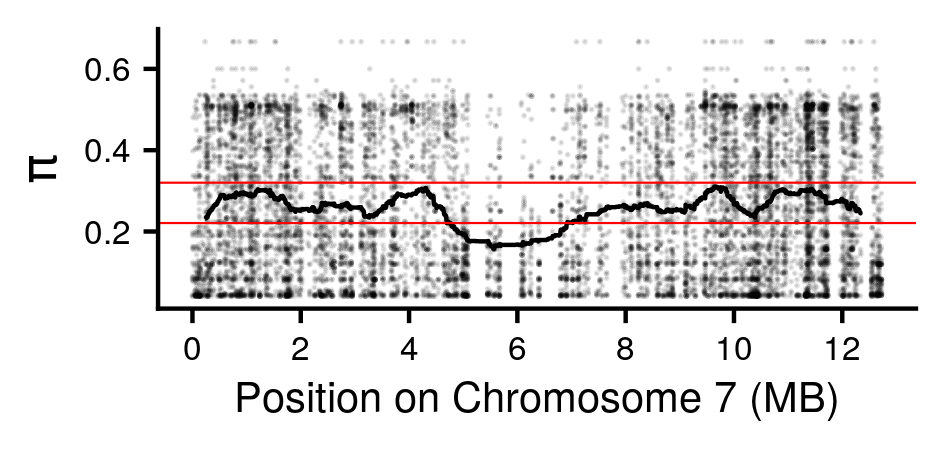

In [10]:
options(repr.plot.width = 3.15, repr.plot.height = 1.515, repr.plot.res = 300)
plot_pi_female

# Tajima's D

Calculate values of Tajima's D in sliding windows of 25000 bp

```bash
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --TajimaD 25000 \
         --keep males.txt \
         --out snigra_males_25kwin
         
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --TajimaD 25000 \
         --keep females.txt \
         --out snigra_females_25kwin
```

In [11]:
TajD <- bind_rows(read_delim("snigra_females_25kwin_Tajima.D", delim="\t",  na =c("", "NA", "-nan")) %>%
                      mutate(., sex = "female"),
                  read_delim("snigra_males_25kwin_Tajima.D", delim="\t",  na =c("", "NA", "-nan")) %>%
                      mutate(., sex = "male"))

Parsed with column specification:
cols(
  CHROM = col_character(),
  BIN_START = col_double(),
  N_SNPS = col_double(),
  TajimaD = col_double()
)

Parsed with column specification:
cols(
  CHROM = col_character(),
  BIN_START = col_double(),
  N_SNPS = col_double(),
  TajimaD = col_double()
)



Strip "Chr" from the chromsome names and rename all scaffolds to SC for convenience in plotting

In [12]:
TajD <- TajD %>%
    mutate(., CHROM = replace(CHROM, str_detect(CHROM, "scaffold"), "SC"),
              CHROM = str_replace(CHROM, "Chr0", ""),
              CHROM = str_replace(CHROM, "Chr15W", "15"),
              CHROM = str_replace(CHROM, "Chr", "")) %>%
    mutate(., CHROM = factor(CHROM, levels = c("1", "2", "3", "4", "5", "6",
                                               "7", "8", "9", "10", "11", "12", 
                                               "13", "14", "15", "16", "17", "18", 
                                               "19", "SC")))

Calculate rolling means for 22 windows (25000 bp), which corresponds to the size of the SLR

In [13]:
TajD <- group_by(TajD, sex) %>%
            mutate(., N_SNPS = replace(N_SNPS, N_SNPS < 5, NA)) %>%
            mutate(., roll22 = rollapply(TajimaD, 22, mean, by = 22, fill = NA, na.rm = TRUE)) %>%
        ungroup()

Calculate the 1% and 99% quantiles for the rolling mean values

In [14]:
female_tajd_rollQuantile.99 <- quantile(filter(TajD, sex == "female") %>% 
                                        select(., roll22) %>% 
                                        as_vector(),0.99,fill=NA,na.rm=TRUE)
female_tajd_rollQuantile.01 <- quantile(filter(TajD, sex == "female") %>% 
                                        select(., roll22) %>% 
                                        as_vector(),0.01,fill=NA,na.rm=TRUE)
male_tajd_rollQuantile.99 <- quantile(filter(TajD, sex == "male") %>% 
                                      select(., roll22) %>% 
                                      as_vector(),0.99,fill=NA,na.rm=TRUE)
male_tajd_rollQuantile.01 <- quantile(filter(TajD, sex == "male") %>% 
                                      select(., roll22) %>% 
                                      as_vector(),0.01,fill=NA,na.rm=TRUE)

### Plot Tajima's D for males on Chromosome 7

The black line is the rolling mean, while the red lines are the 1% and 99% values across the genome

In [15]:
plot_tajd_male <- filter(TajD, CHROM == "7" & sex == "male") %>%
    ggplot(., aes(x=BIN_START, y=TajimaD)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.4, size=0.25) +
        scale_color_manual(values = rep(c("black", "darkgray"), 23 )) +
        scale_x_continuous( breaks = c(0,2000000,4000000,6000000,8000000,10000000,12000000),
                           labels=c("0","2","4","6","8","10","12")) +
        scale_y_continuous(limits = c(-3.5,3.5), expand = c(0, 0), 
                           breaks = c(-3,-2,-1, 0, 1, 2, 3), 
                           labels = c("-3","-2","-1", "0", "1", "2", "3") ) + 
        xlab("Position on Chromosome 7 (MB)") +
        ylab("Tajima's D") +
        theme(legend.position = "none",
            axis.title.x = element_text(size=10), 
            axis.title.y = element_text(size=10), 
            axis.text.y = element_text(size=8),
            axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(TajD, CHROM == "7" & sex == "male") %>% 
                                     select(., TajimaD), 22, fill=NA, na.rm=TRUE)))  + 
        geom_hline(yintercept=male_tajd_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=male_tajd_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 147 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_path).”


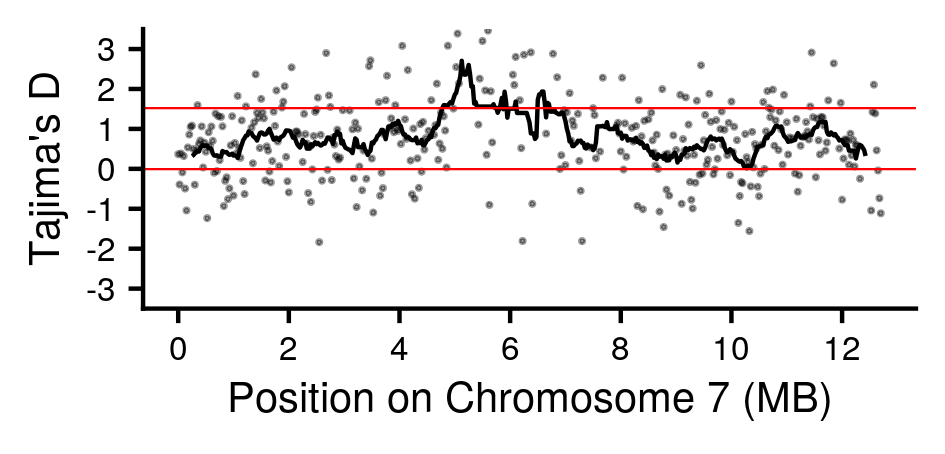

In [16]:
options(repr.plot.width = 3.15, repr.plot.height = 1.515, repr.plot.res = 300)
plot_tajd_male

### Plot Tajima's D for females on Chromosome 7

In [17]:
plot_tajd_female <- filter(TajD, CHROM == "7" & sex == "female") %>%
    ggplot(., aes(x=BIN_START, y=TajimaD)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.4, size=0.25) +
        scale_color_manual(values = rep(c("black", "darkgray"), 23 )) +
        scale_x_continuous( breaks = c(0,2000000,4000000,6000000,8000000,10000000,12000000), 
                           labels=c("0","2","4","6","8","10","12")) +
        scale_y_continuous(limits = c(-3.5,3.5), expand = c(0, 0), 
                           breaks = c(-3,-2,-1, 0, 1, 2, 3), 
                           labels = c("-3","-2","-1", "0", "1", "2", "3") ) + 
        xlab("Position on Chromosome 7 (MB)") +
        ylab("Tajima's D") +
        theme(legend.position = "none",
            axis.title.x = element_text(size=10), 
            axis.title.y = element_text(size=10), 
            axis.text.y = element_text(size=8),
            axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(TajD, CHROM == "7" & sex == "female") %>% 
                                 select(., TajimaD), 22, fill=NA, na.rm=TRUE))) + 
        geom_hline(yintercept=female_tajd_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=female_tajd_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 142 rows containing missing values (geom_point).”
Warning message:
“Removed 21 rows containing missing values (geom_path).”


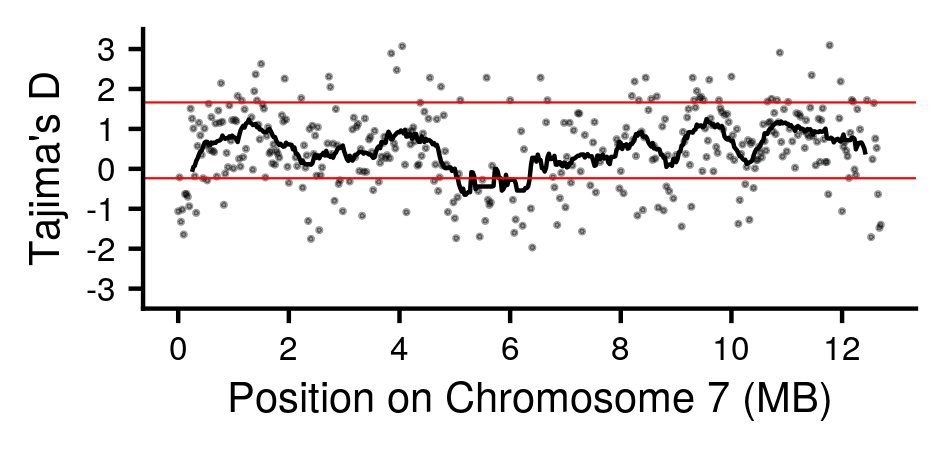

In [18]:
options(repr.plot.width = 3.15, repr.plot.height = 1.515, repr.plot.res = 300)
plot_tajd_female

In [19]:
TajD <- TajD %>%
        group_by(CHROM) %>%
        summarize(chr_len=max(BIN_START)) %>%
        mutate(tot=cumsum(chr_len)-chr_len) %>%
        select(-chr_len) %>%
        left_join(TajD, ., by=c("CHROM"="CHROM")) %>%
        arrange(CHROM, BIN_START) %>%
        mutate( BIN_START_cum=BIN_START+tot)

Create a convenience data frame that contains the center of each of the chromosomes for plotting the axis labels. Because we've broken the scaffold names, just make that value the largest value of the cumulative BP variable

In [20]:
axisdf = TajD %>% group_by(CHROM) %>% summarize(center=( max(BIN_START_cum) + min(BIN_START_cum) ) / 2 )
str(axisdf)

Classes ‘tbl_df’, ‘tbl’ and 'data.frame':	20 obs. of  2 variables:
 $ CHROM : Factor w/ 20 levels "1","2","3","4",..: 1 2 3 4 5 6 7 8 9 10 ...
 $ center: num  7850000 24200000 39800000 54850000 71837500 ...


### Plot Tajima's D across the genome of males

In [21]:
plot_tajd_male_genome <- filter(TajD, sex == "male") %>%
    ggplot(., aes(x=BIN_START_cum, y=TajimaD)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.8, size=0.05) +
        scale_color_manual(values = rep(c("gray48", "gray81"), 23 )) +
        # custom X axis:
        scale_x_continuous( label = axisdf$CHROM, breaks= axisdf$center ) +
        scale_y_continuous(limits = c(-2.0,4.0), expand = c(0, 0) ) +
        xlab("Chromosome") +
        ylab("Tajima's D") +
        theme(legend.position="none",
        axis.title.x = element_text(size=12), 
        axis.title.y = element_text(size=12), 
        axis.text.y = element_text(size=8),
        axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(TajD, sex == "male") %>% 
                                 select(., TajimaD), 100, fill=NA, na.rm=TRUE)), 
                  color="#2166AC", size=0.3) + 
        geom_hline(yintercept=male_tajd_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=male_tajd_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 2616 rows containing missing values (geom_point).”
Warning message:
“Removed 99 rows containing missing values (geom_path).”


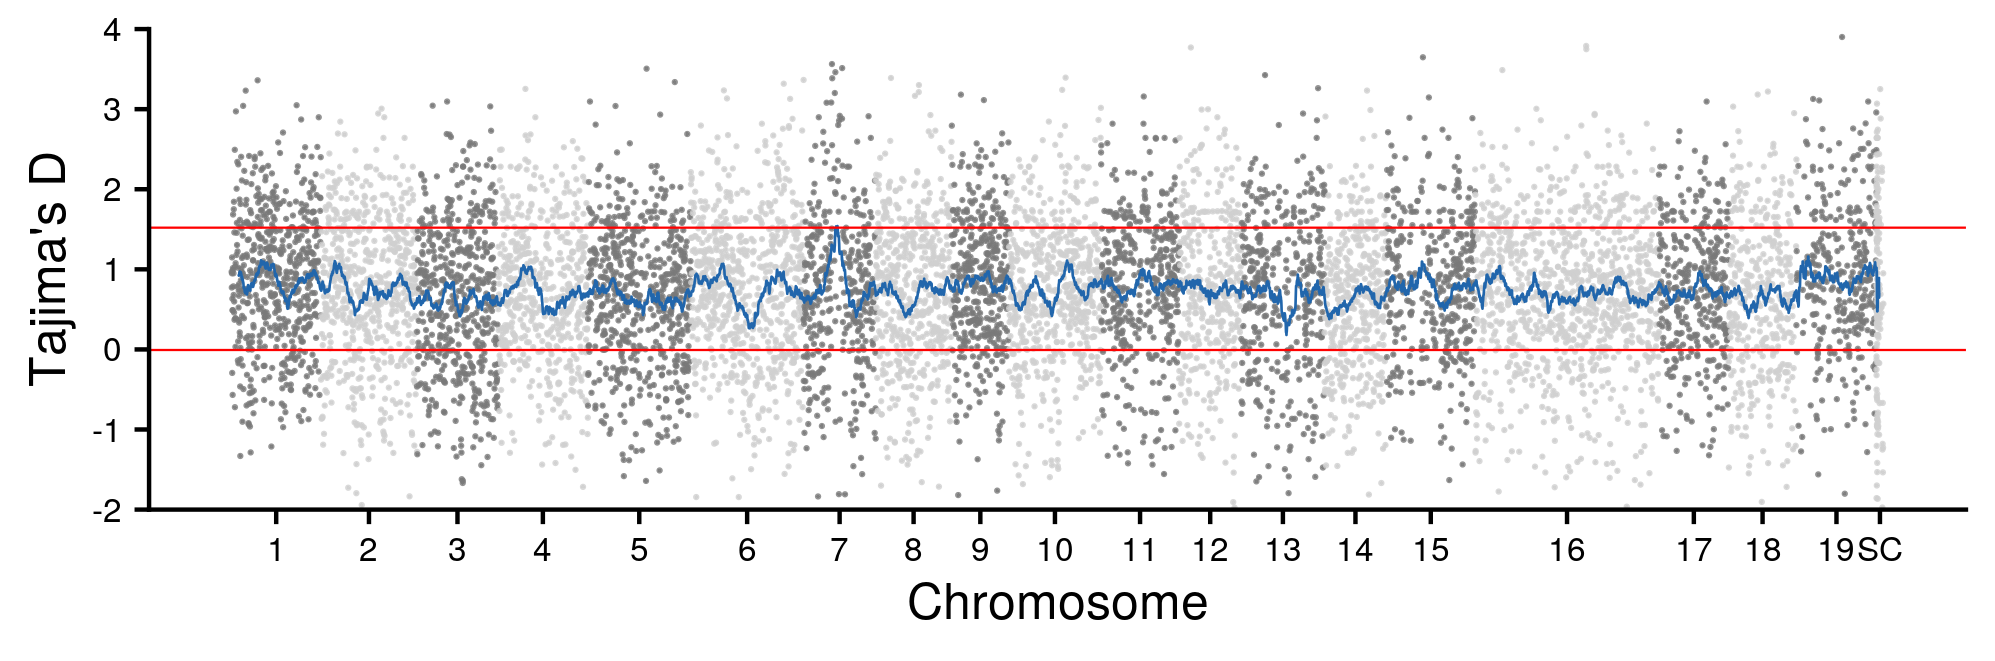

In [22]:
options(repr.plot.width = 6.653, repr.plot.height = 2.205, repr.plot.res = 300)
plot_tajd_male_genome

### Plot Tajima's D across the genome of females

In [23]:
plot_tajd_female_genome <- filter(TajD, sex == "female") %>%
    ggplot(., aes(x=BIN_START_cum, y=TajimaD)) +
        geom_point( aes(color=as.factor(CHROM)), alpha=0.8, size=0.05) +
        scale_color_manual(values = rep(c("gray48", "gray81"), 23 )) +
        # custom X axis:
        scale_x_continuous( label = axisdf$CHROM, breaks= axisdf$center ) +
        #scale_y_continuous(limits = c(-4.0,4.0), expand = c(0, 0) ) +    
        xlab("Chromosome") +
        ylab("Tajima's D") +
        theme(legend.position="none",
        axis.title.x = element_text(size=12), 
        axis.title.y = element_text(size=12), 
        axis.text.y = element_text(size=8),
        axis.text.x = element_text(size=8)) + 
        geom_line(aes(y=rollmean(filter(TajD, sex == "female") %>% 
                                 select(., TajimaD), 100, fill=NA, na.rm=TRUE)), 
                  color="#2166AC", size=0.3) + 
        geom_hline(yintercept=female_tajd_rollQuantile.01, color="red", size=0.25) + 
        geom_hline(yintercept=female_tajd_rollQuantile.99, color="red", size=0.25)

Warning message:
“Removed 2541 rows containing missing values (geom_point).”
Warning message:
“Removed 99 rows containing missing values (geom_path).”


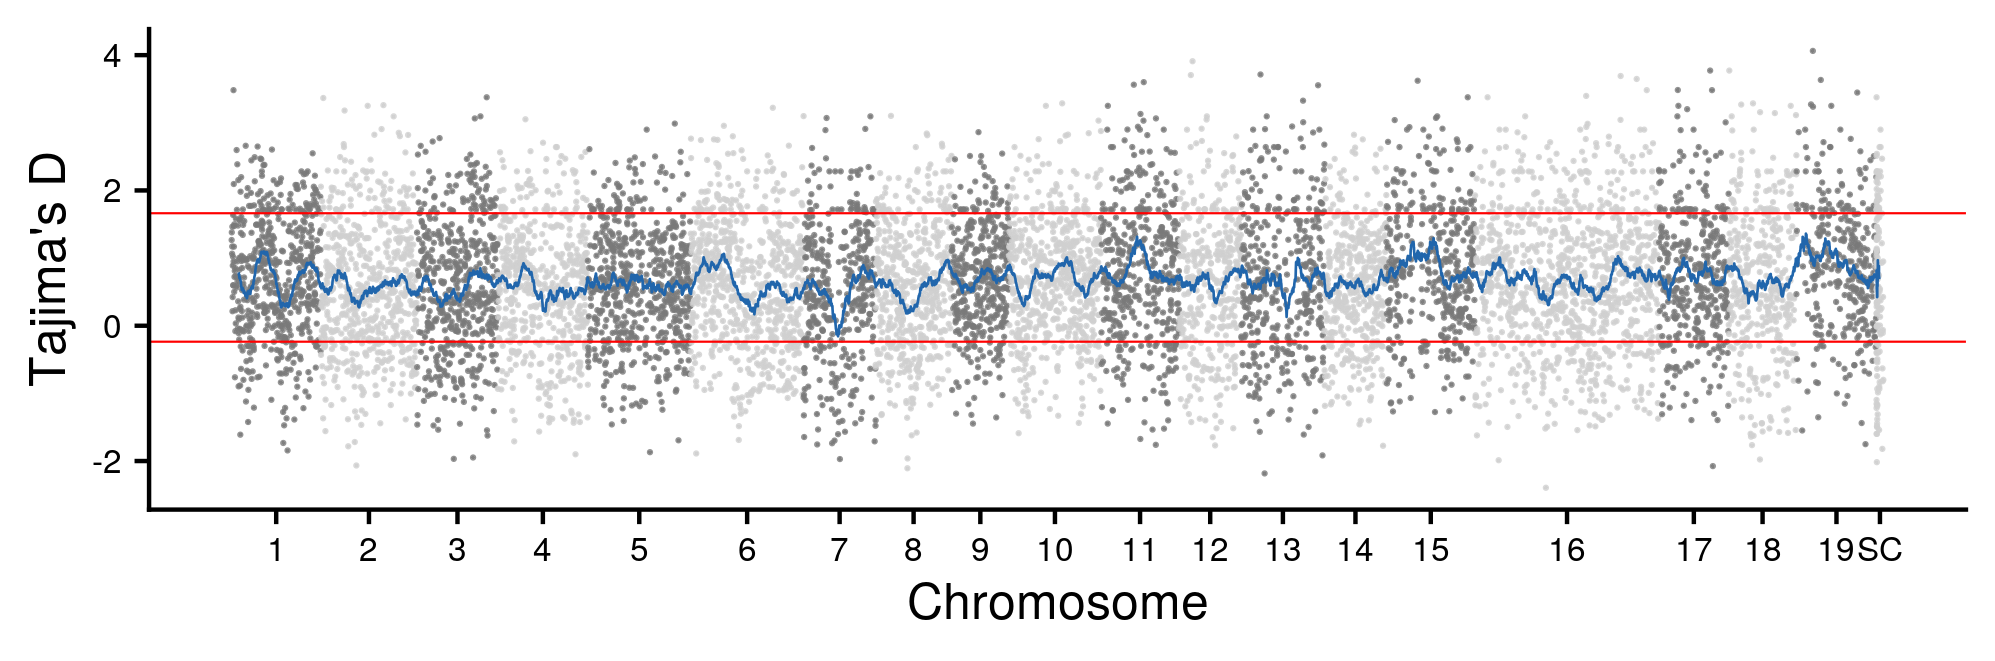

In [24]:
options(repr.plot.width = 6.653, repr.plot.height = 2.205, repr.plot.res = 300)
plot_tajd_female_genome

# Decay of LD

To estimate the decay of linkage disequilibrium we use VCFtools to calculate the squared allele frequency correlation $r^{2}$ for pairs of alleles. To compare rates of decay, we focus on the SLR (Chr07:4886397-6807813) as well as an upstream region of Chr07 that should be freely recombining (Chr7:100000-4000000). We focus only on loci that are a minimum distance of 1000 bp apart, that have a minor allele frequency > 0.1, and that have a minimum value of $r^{2}$ of 0.01 to winnow this down to a reasonable number of pairwise values.

```bash
        
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --geno-r2 \
         --maf 0.10 \
         --ld-window-bp-min 1000 \
         --min-r2 0.01 \
         --chr Chr07 \
         --from-bp 4886397 \
         --to-bp 6807813 \
         --keep males.txt \
         --out snigraLDmales_SLR

vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --geno-r2 \
         --maf 0.10 \
         --ld-window-bp-min 1000 \
         --min-r2 0.01 \
         --chr Chr07 \
         --from-bp 4886397 \
         --to-bp 6807813 \
         --keep females.txt \
         --out snigraLDfemales_SLR
                
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --geno-r2 \
         --maf 0.10 \
         --ld-window-bp-min 1000 \
         --min-r2 0.01 \
         --chr Chr07 \
         --from-bp 100000 \
         --to-bp 4000000 \
         --keep males.txt \
         --out snigraLDmales_chr7_01-4M

vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --geno-r2 \
         --maf 0.10 \
         --ld-window-bp-min 1000 \
         --min-r2 0.01 \
         --chr Chr07 \
         --from-bp 100000 \
         --to-bp 4000000 \
         --keep females.txt \
         --out snigraLDfemales_chr7_01-4M

```

These files are quite large, so before reading into R I have subset the files for just the sites where there are at least 18 individuals with called genotypes

```bash
 
awk -F "\t" '{ if ($4 > 18) { print $1"\t"$2"\t"$3"\t"$4"\t"$5 } }' snigraLDmales_SLR.geno.ld > LDmales_SLR_sub.geno.ld

awk -F "\t" '{ if ($4 > 18) { print $1"\t"$2"\t"$3"\t"$4"\t"$5 } }' snigraLDfemales_SLR.geno.ld > LDfemales_SLR_sub.geno.ld

awk -F "\t" '{ if ($4 > 18) { print $1"\t"$2"\t"$3"\t"$4"\t"$5 } }' snigraLDmales_chr7_01-4M.geno.ld > LDmales_ds_sub.geno.ld

awk -F "\t" '{ if ($4 > 18) { print $1"\t"$2"\t"$3"\t"$4"\t"$5 } }' snigraLDfemales_chr7_01-4M.geno.ld > LDfemales_ds_sub.geno.ld
```

In [25]:
r2_frame <- bind_rows(read_delim('LDmales_ds_sub.geno.ld', delim="\t",  na =c("", "NA", "-nan")) %>%
                         mutate(., Sex = "Male", Region = "Background"),
                     read_delim('LDfemales_ds_sub.geno.ld', delim="\t",  na =c("", "NA", "-nan")) %>%
                         mutate(., Sex = "Female", Region = "Background"),
                     read_delim('LDmales_SLR_sub.geno.ld', delim="\t",  na =c("", "NA", "-nan")) %>%
                         mutate(., Sex = "Male", Region = "SLR"),
                     read_delim('LDfemales_SLR_sub.geno.ld', delim="\t",  na =c("", "NA", "-nan")) %>%
                         mutate(., Sex = "Female", Region = "SLR"))

Parsed with column specification:
cols(
  CHR = col_character(),
  POS1 = col_double(),
  POS2 = col_double(),
  N_INDV = col_double(),
  `R^2` = col_double()
)

Parsed with column specification:
cols(
  CHR = col_character(),
  POS1 = col_double(),
  POS2 = col_double(),
  N_INDV = col_double(),
  `R^2` = col_double()
)

Parsed with column specification:
cols(
  CHR = col_character(),
  POS1 = col_double(),
  POS2 = col_double(),
  N_INDV = col_double(),
  `R^2` = col_double()
)

Parsed with column specification:
cols(
  CHR = col_character(),
  POS1 = col_double(),
  POS2 = col_double(),
  N_INDV = col_double(),
  `R^2` = col_double()
)



Calculate the distance between loci

In [26]:
r2_frame <- group_by(r2_frame, Sex, Region) %>%
                mutate(., dist = POS2 - POS1) %>%
            ungroup()

The following function implements the code described by Fabio Marroni in [this blog post](https://fabiomarroni.wordpress.com/2011/08/09/estimate-decay-of-linkage-disequilibrium-with-distance/), and described in greater detail in [their publication from 2011](https://www.doi.org/10.1007/s11295-011-0391-5). It takes as input a vector of distances in base pairs, values of $r^2$ from vcftools, the number of chromosomes (in our case with a minimum of 18 individuals I'm using 36), and a starting value for C (to be estimated by the nls model), which is the product of the recombination fraction between sites and distance in bp.

In [27]:
estimate_decay <- function(data_frame, sex, region, n, HW.st) {
    require(nlstools)
    require(dplyr)
    distance = filter(data_frame, Sex == sex, Region == region) %>% 
                   select(., dist) %>% as_vector() %>% unname()
    LD.data = filter(data_frame, Sex == sex, Region == region) %>% 
                  select(., `R^2`) %>% as_vector() %>% unname()
    HW.nonlinear<-nls(LD.data~((10+C*distance)/
                               ((2+C*distance)*(11+C*distance)))*
                              (1+((3+C*distance)*(12+12*C*distance+(C*distance)^2))/
                                                 (n*(2+C*distance)*(11+C*distance))),
                      start=HW.st,control=nls.control(maxiter=100))
    tt<-summary(HW.nonlinear)
    new.rho<-tt$parameters[1]
    rho.ci <- confint2(HW.nonlinear, level = 0.95)
    fpoints<-((10+new.rho*distance)/
              ((2+new.rho*distance)*(11+new.rho*distance)))*
              (1+((3+new.rho*distance)*(12+12*new.rho*distance+(new.rho*distance)^2))/
                                       (n*(2+new.rho*distance)*(11+new.rho*distance)))
    fpoints.lower <- ((10+rho.ci[1]*distance)/
                      ((2+rho.ci[1]*distance)*(11+rho.ci[1]*distance)))*
                      (1+((3+rho.ci[1]*distance)*(12+12*rho.ci[1]*distance+(rho.ci[1]*distance)^2))/
                                                 (n*(2+rho.ci[1]*distance)*(11+rho.ci[1]*distance)))
    fpoints.upper <- ((10+rho.ci[2]*distance)/
                      ((2+rho.ci[2]*distance)*(11+rho.ci[2]*distance)))*
                      (1+((3+rho.ci[2]*distance)*(12+12*rho.ci[2]*distance+(rho.ci[2]*distance)^2))/
                                                 (n*(2+rho.ci[2]*distance)*(11+rho.ci[2]*distance)))
    LD.decay<-data.frame(distance, LD.data, fpoints, fpoints.lower, fpoints.upper)
    return(LD.decay)
}

Use the above function to estimate the decay of LD across the regions

In [28]:
estimate_frame <- bind_rows(estimate_decay(r2_frame, "Male", "Background", 36, c(C=0.1)) %>% 
                                mutate(., Sex = "Male", Region = "Background"),
                            estimate_decay(r2_frame, "Male", "SLR", 36, c(C=0.1)) %>% 
                                mutate(., Sex = "Male", Region = "SLR"),
                            estimate_decay(r2_frame, "Female", "Background", 36, c(C=0.1)) %>% 
                                mutate(., Sex = "Female", Region = "Background"),
                            estimate_decay(r2_frame, "Female", "SLR", 36, c(C=0.1)) %>% 
                                mutate(., Sex = "Female", Region = "SLR"))

The following function also implements the code described by Fabio Marroni in [this blog post](https://fabiomarroni.wordpress.com/2011/08/09/estimate-decay-of-linkage-disequilibrium-with-distance/), and calculates the distance at which the estimates of LD have decayed by half.

In [29]:
half_distance <- function(data_frame, sex, region) {
    require(dplyr)
    sub_frame <- filter(data_frame, Sex == sex, Region == region)
    h.decay <- max(sub_frame$fpoints) / 2
    half.decay.distance <- sub_frame$distance[which.min(abs(sub_frame$fpoints - h.decay))]
    return(half.decay.distance)
}

In [30]:
half_distance(estimate_frame, "Male", "Background")
half_distance(estimate_frame, "Male", "SLR")
half_distance(estimate_frame, "Female", "Background")
half_distance(estimate_frame, "Female", "SLR")

[1] 60157

[1] 1709319

[1] 51477

[1] 86056

Calculate the maximum distance across the SLRs for males and females, to be used as the max X-axis in the plot of decay

In [31]:
filter(estimate_frame, Sex == "Male", Region == "SLR") %>% select(., distance) %>% max()
filter(estimate_frame, Sex == "Female", Region == "SLR") %>% select(., distance) %>% max()

[1] 1921416

[1] 1912584

Create a ggplot object to plot the decay of LD

In [32]:
ld_plot <- estimate_frame %>% 
    mutate(., Sex = factor(Sex, levels = c("Male", "Female")),
           Region = factor(Region, levels = c("SLR", "Background"))) %>%
    ggplot(., aes(x=distance, y=fpoints, fill = Sex, linetype = Region)) +
           geom_ribbon(aes(ymin=fpoints.lower, ymax=fpoints.upper, size = 0.01), alpha = 0.3) +
           geom_line(aes(x=distance, y=fpoints, linetype = Region, color = Sex,)) +
           scale_x_continuous(limits = c(0, 1912584),
                              labels = c(0, 0.5, 1, 1.5, 2),
                              breaks = c(0, 500000, 1000000, 1500000, 2000000)) +
           scale_color_manual(values = c('blue3', 'red4')) +
           scale_fill_manual(values = c('blue3', 'red4')) +
           scale_linetype_manual(values = c('dashed', 'solid')) +
           xlab("Distance (MB)") + 
           ylab(expression(r^2)) +
           theme(legend.position="none",
                plot.margin = margin(10, 24, 10, 10))

Warning message:
“Removed 320408 rows containing missing values (geom_path).”


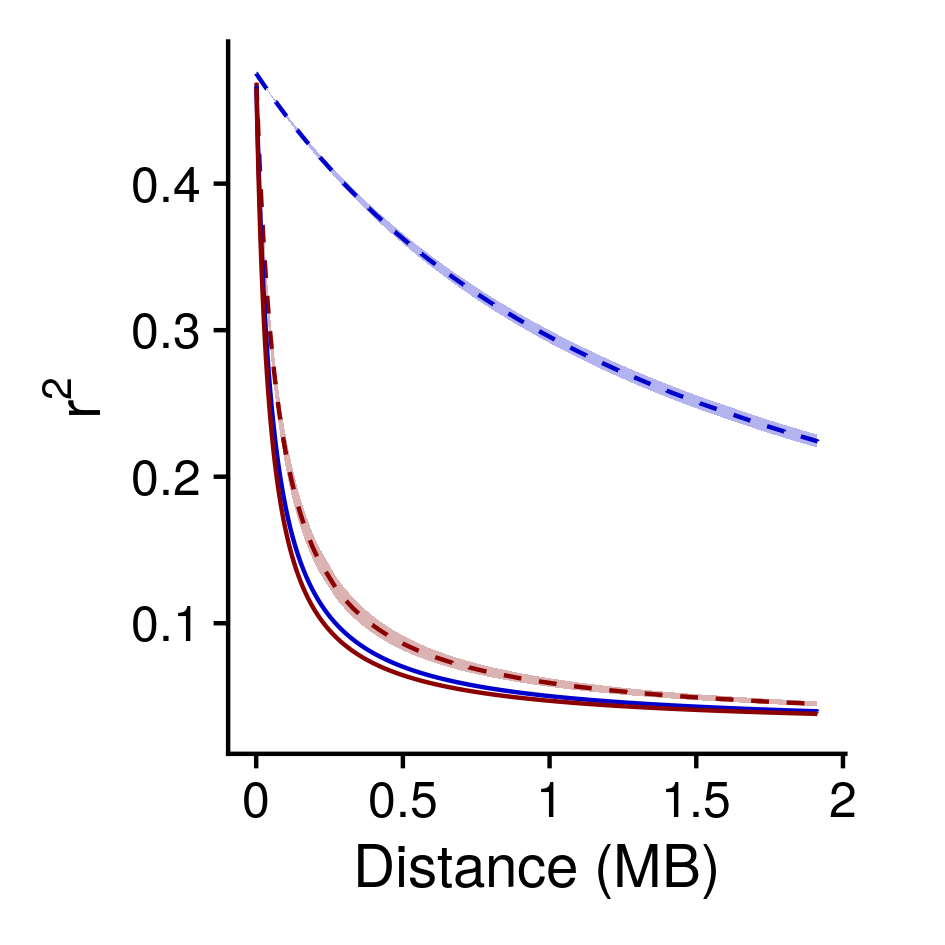

In [33]:
options(repr.plot.width = 3.15, repr.plot.height = 3.15, repr.plot.res = 300)
ld_plot

# Calculate relatedness (&phi;) between all individuals

We use VCFtools to calculate relatedness among individuals in the *S. nigra* dataset as &phi; (relatedness coefficient: 0.25 = sibs, 0.125 = half-sibs, etc).

```bash
# BASH CODE
vcftools --gzvcf snigra.filtered.snps.vcf.gz \
         --out snigra \
         --relatedness2
```

## Summarize and plot &phi;

Read the kinship values into R:

In [34]:
snigra_relatedness <- read_delim("snigra.relatedness2", delim = "\t")

Parsed with column specification:
cols(
  INDV1 = col_character(),
  INDV2 = col_character(),
  N_AaAa = col_double(),
  N_AAaa = col_double(),
  N1_Aa = col_double(),
  N2_Aa = col_double(),
  RELATEDNESS_PHI = col_double()
)



Summarize the distribution of &phi;. From these results, it appears that the average individual is between a half-sib and a full-sib so this population appears very inbred. This may explain why our attempt at linkage mapping failed.

In [35]:
summary(filter(snigra_relatedness, INDV1 != INDV2) %>% 
            select(., RELATEDNESS_PHI))

 RELATEDNESS_PHI  
 Min.   :0.02086  
 1st Qu.:0.14846  
 Median :0.17721  
 Mean   :0.17610  
 3rd Qu.:0.20308  
 Max.   :0.38452  

Expand the data into a matrix, and plot using the function corrplot:

In [36]:
vars <- unique(c(snigra_relatedness$INDV1, snigra_relatedness$INDV2))
df <- cbind.data.frame(snigra_relatedness$INDV1, snigra_relatedness$INDV2, snigra_relatedness$RELATEDNESS_PHI)
colnames(df) <- c("var1", "var2", "r")
cor.df <- expand.grid(vars, vars)
cor.df <- rbind(merge(cor.df, df, by.x=c('Var1', 'Var2'), by.y=c('var1', 'var2')),
                merge(cor.df, df, by.x=c('Var2', 'Var1'), by.y=c('var1', 'var2')),
                data.frame(Var1=vars, Var2=vars, r=1))

cor.mat <- dcast(df, var1~var2, value.var='r')
rownames(cor.mat) <- cor.mat[,1]
cor.mat <- as.matrix(cor.mat[-1])

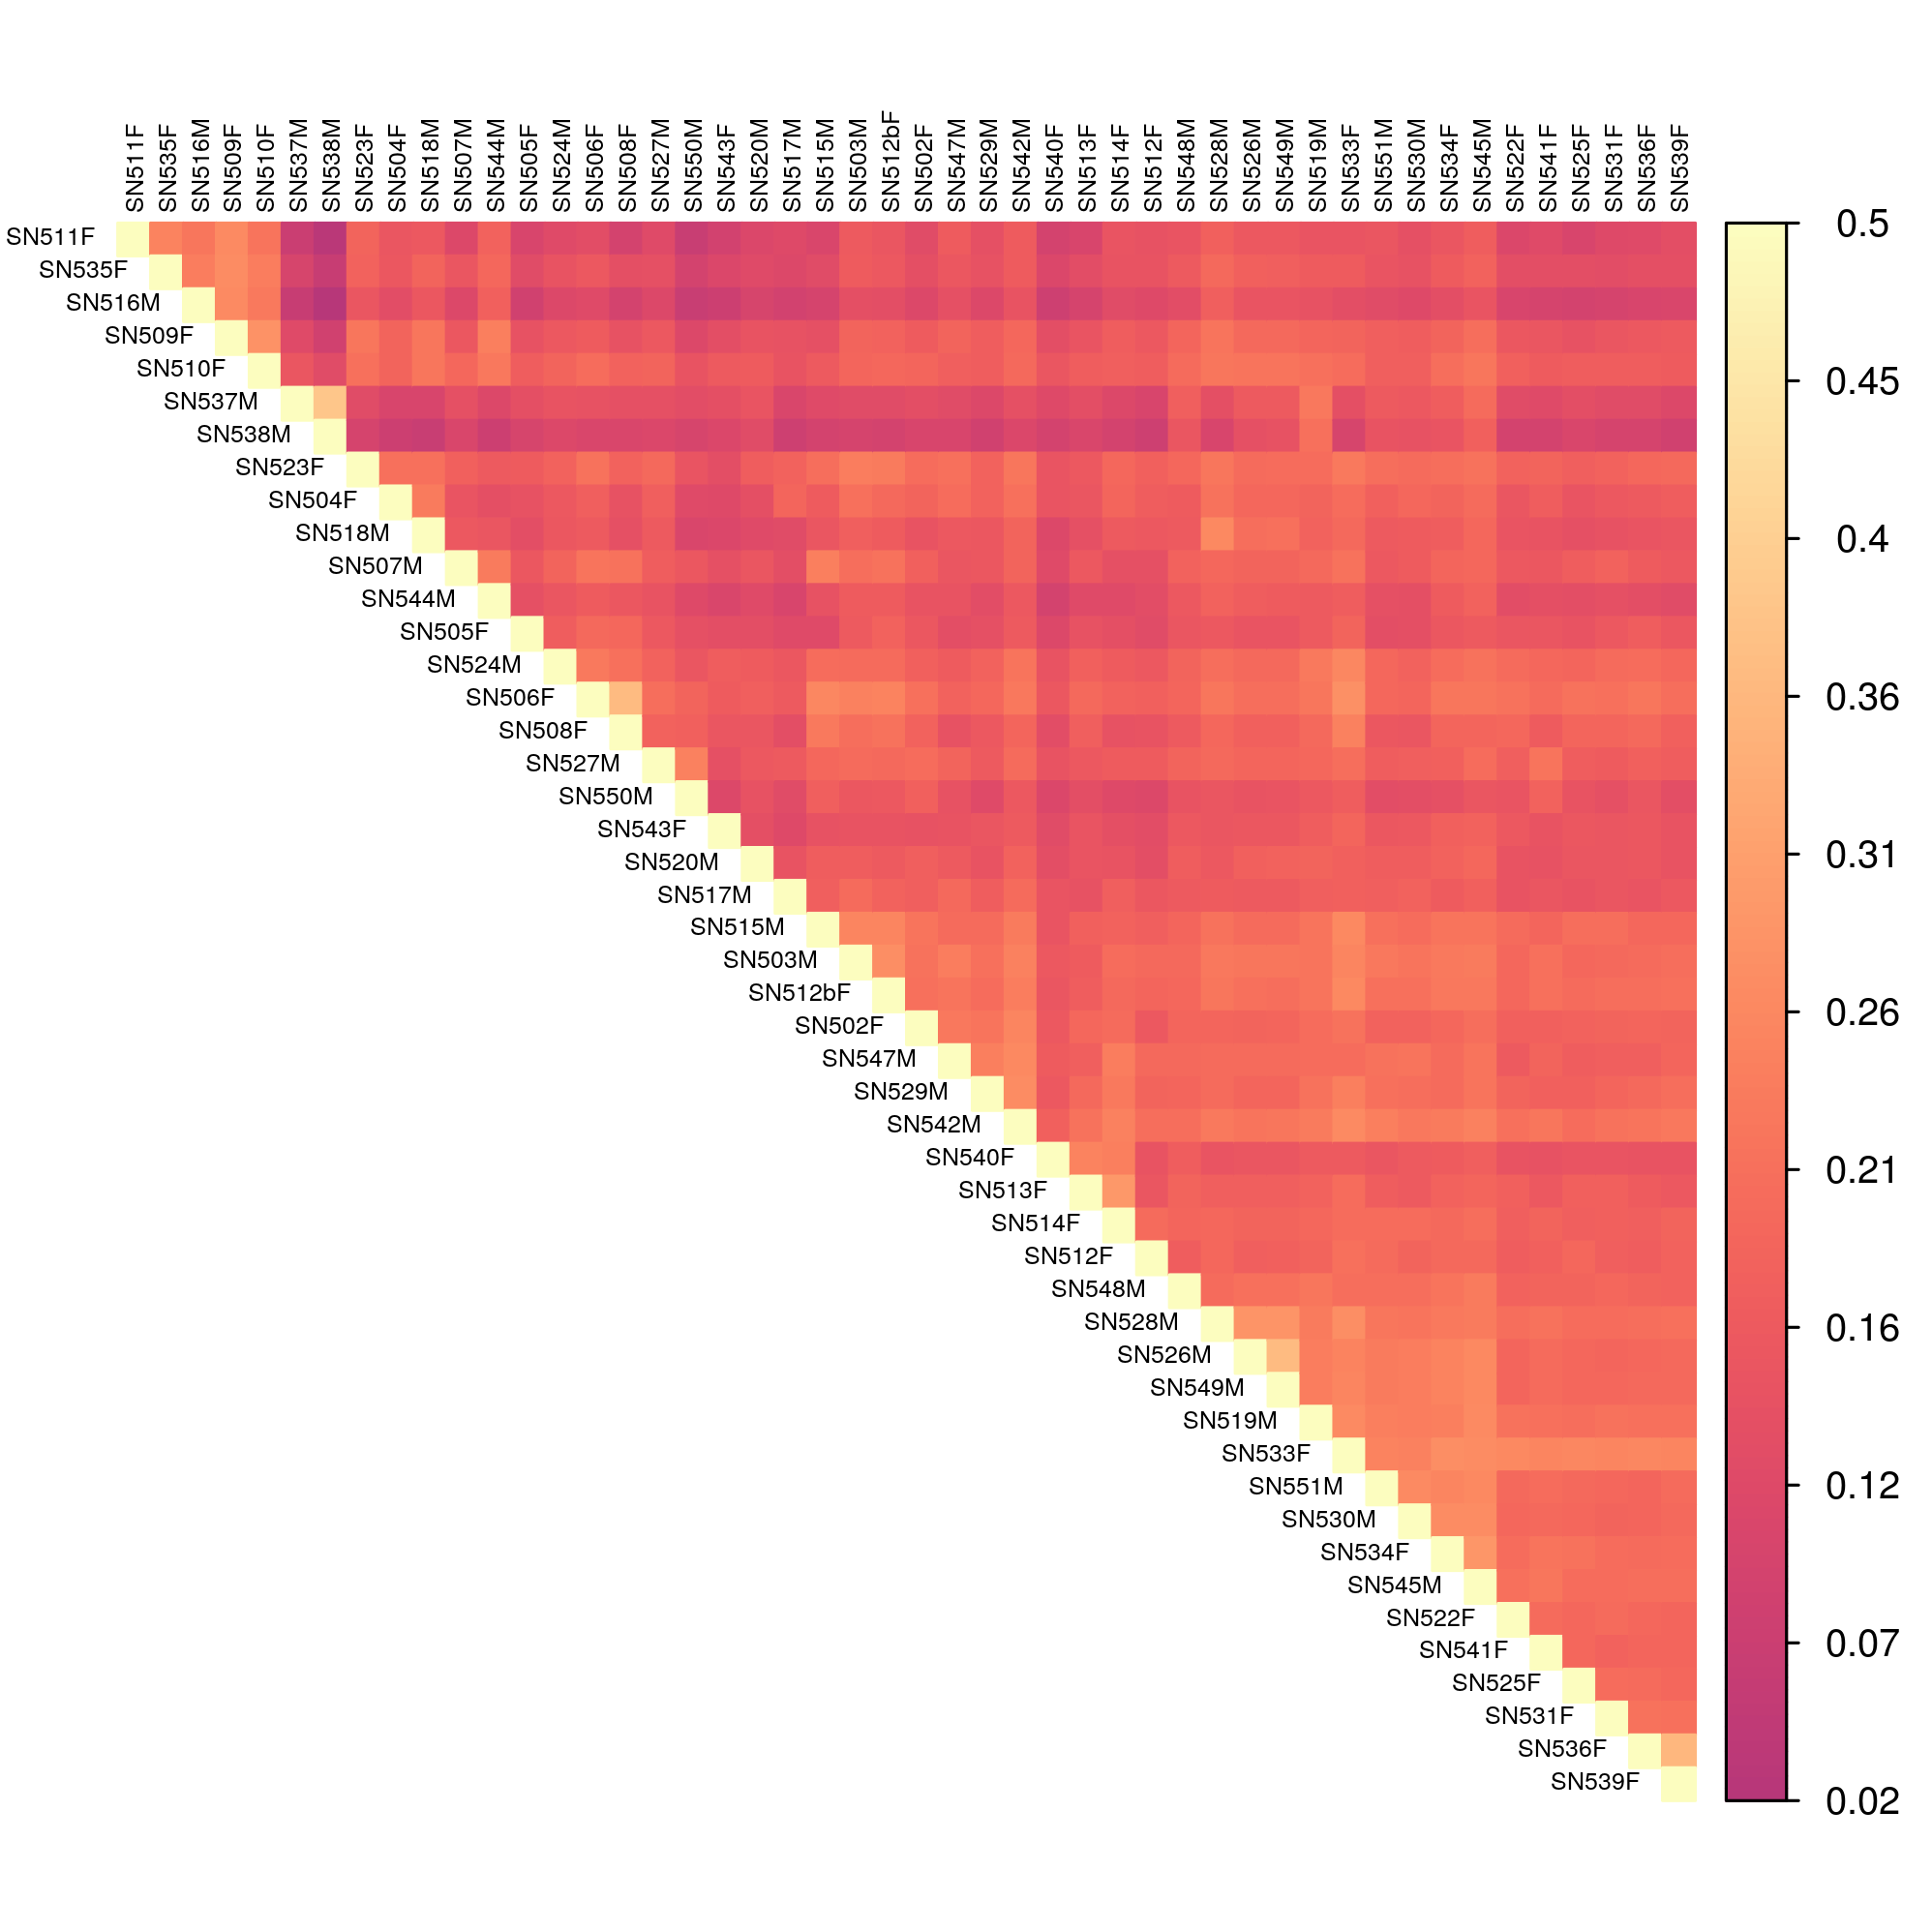

In [37]:
options(repr.plot.width = 6.654, repr.plot.height = 6.654, repr.plot.res = 300)
corrplot(cor.mat, type="upper", order="hclust", is.corr=FALSE, method="color", tl.cex=0.50, tl.col="black", col=magma(256))